In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
from density_correlations import oil_density
from data import Vn, d15_6, roW
from bvp import OrthogonalCollocation
from kinetics import rHDS, rHDN_NB, rHDN_B, rHDA, ft_reactants, effective_reactions
from solubility import Henry_coefficient2_fun, Henry_coefficient4_fun
from mass_balance_equations import k1S_fun, k2S_fun, k4S_fun, k2L_aL_fun, k4L_aL_fun

In [2]:
T = 380+273.15  #Temperature in K

P = 5.3e6 #Pressure in Pa

API = 22

Mm1 = 441.9 #molecuar weigth of the oil.

rho0 = d15_6*roW #Specific gravity of oil.

rhoL = oil_density(rho0,P,T) #density of oil in g/cm^3

rhob = 0.8163 #bulk density in g/cm^3

dp = 0.254 #equivalent diameter in cm

z = 31.54 #length of the reactor

LHSV = 2 # Liquid Hourly Space Velocity in h-1.

diameter_reactor = 2.54 #diameter of the reactor in cm

Ac = np.pi*diameter_reactor**2/4

V_reactor = Ac*z  #Volume of the reactor

fi = 356 #H2/ Oil Ratio std m3/m3

uL = LHSV/3600*V_reactor/Ac #superficial liquid velocity in cm/s.

GL = uL*rhoL #superficial gas velocity in cm/s

uG = uL*(1e5/P)*(T/273.15)*fi #superficial gas velocity in cm/s

def get_bed_fraction(DR, dp):

    return 0.38 + 0.073*(1 + (DR/dp - 2)**2/(DR/dp)**2)


porosity = get_bed_fraction(2.54, 0.254) #value calculate using values of first article

def aS_fun(dp,porosity):

    '''Gets the specific surface area of the packing.

        Parameters
        ----------
        dp: int or float
            equivalent diameter in cm.

        porosity: int or float
                  The void fraction of the catalystic bed.

        Return
        ------
        a_super: float
                 The specific surface area of the packing in cm^-1.
    '''

    return 6*(1-porosity)/dp

aS = aS_fun(dp,porosity)

In [3]:
H2 = Henry_coefficient2_fun(rho0, P,T)

H4 = Henry_coefficient4_fun(rho0, P,T)

k1S_aS = k1S_fun(rho0, P, T, API, GL, aS)*aS

k2S_aS = k2S_fun(rho0, P, T, API, GL, aS)*aS

k4S_aS = k4S_fun(rho0, P, T, API, GL, aS)*aS

k2L_aL = k2L_aL_fun(rho0, P, T, API, GL)

k4L_aL = k4L_aL_fun(rho0, P, T, API, GL)

In [4]:
class Reactor():

    def __init__(self, z, LHSV, fi, catalyst_diameter, dp, rhob, T, P):

        self.z = z
        self.LHSV = LHSV
        self.fi = fi
        self.catalyst_diameter = catalyst_diameter
        self.dp = dp
        self.rhob = rhob
        self.T = T
        self.P = P
        self.Ac = np.pi * catalyst_diameter**2 / 4
        self.V_reactor = Ac * z
        self.uL = self.LHSV/3600 * self.V_reactor / self.Ac
        self.ug = uL*(1e5/P)*(T/273.15)*fi
        self.GL = self.uL * oil_density(rho0,P, T)


    def _transport_eq(self, r, y, dy, d2y, yb, *args): #partial equations
        return d2y - ft_reactants(r, y, *args)
    
    def _bc_eq(self, r, y, dy, d2y, yb, *args):
        return y - yb
    

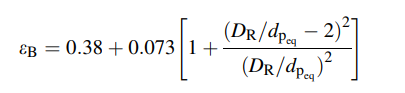

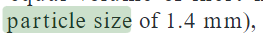

In [5]:
dia_cat = 0.14
n_points = 6
ivp_rtol=1e-16

In [6]:
def bc_eq(r, y, dy, d2y, yb, *args):  #boundary conditions
    return y - yb

def transport_eq(r, y, dy, d2y, yb, *args): #partial equations
    return d2y - ft_reactants(r, y, *args)

In [7]:
collocation = OrthogonalCollocation(
                transport_eq,
                bc_eq,
                n_points, 3, x0=0, x1=dia_cat/2)

In [8]:
w0 = 0.02009 #weigth fraction of sulfur.
w1 = (1284 - 518)*1e-6 #weigth fraction of non basic nitrogen.
w2 = 518*1e-6 #weigth fraction of basic nitrogen.
w3= 0.419 #weigth fraction of aromatic compounds.

## INITIAL CONDITIONS

In [9]:
cL00 = rhoL*w0/Mm1
cL10 = rhoL*w1/Mm1
cL20 = rhoL*w2/Mm1
cL30 = rhoL*w3/Mm1
pG40 = 5.3
pG50 = 0
cL40 = pG40/H2 #inlet concentration of hydrogen in mol/cm^3 .
cL50 = 0 #inlet concentration of hidrogen sulfite in mol/cm^3 .
cL60 = 0 #inlet concentration of naphtneses in mol/cm^3.
z0=0


In [11]:
def mass_balance_gas_phase2(p2G, C2L, uG = uG, R=8.3145, T = T):

    return - k2L_aL * (p2G / H2 - C2L) * R * T / uG 

def mass_balance_gas_phase4(p4G, C4L, uG = uG, R=8.3145, T = T):

    return - k4L_aL * (p4G / H4- C4L) * R * T / uG

def mass_balance_gas_liquid_phase2(p2G, C2L, C2S, uL = uL):

    return (k2L_aL * (p2G / H2 - C2L) -  k2S_aS * (C2L - C2S)) / uL

def mass_balance_gas_liquid_phase4(p4G, C4L, C4S, uL = uL):
    
    return (k4L_aL * (p4G / H4 - C4L) -  k4S_aS * (C4L - C4S)) / uL

def mass_balance_liquid(C1L, C1S, uL = uL): 

    return - (C1L - C1S) * k1S_aS / uL

In [12]:
def constraints(C,variables, z):
    
    ni0 = -1
    ni1 = -1
    ni2 = 1
    ni3 = -1
    ni4 = -15
    ni5 = 9
    ni6 = 1

    if z == 0:

        root_method = 'lm'
        C[C == 0] = ivp_rtol
        y0 = np.column_stack((C,) * (n_points + 1))

    else:
        y0 = collocation.y
        root_method = 'hybr'

    args_ft = (C, variables[7], T)
    collocation.collocate(y0, args=args_ft, method=root_method)

    args_reactions = (variables[7], T)
    eff = collocation.effectiveness(effective_reactions, args_reactions)

    print(eff)

    
    F = np.empty((7))
    F[0] =  - ni0*eff[0] * rhob * rHDS(C,T)  -  k1S_aS*(variables[0] - C[0])
    F[1] =  - ni1*eff[1] * rhob * rHDN_NB(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[1] - C[1])
    F[2] =  - ni2*eff[2] * rhob * rHDN_B(C*Mm1/rhoL*100, T)*rhoL/Mm1  -  k1S_aS * (variables[2] - C[2])
    F[3] =  - ni3*eff[3] * rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[3] - C[3])
    F[4] =  - ni4*rhob * eff[0] * rHDS(C,T)   - k2S_aS * (variables[4] - C[4])
    F[5] =  - ni5*rhob * eff[0] * rHDS(C,T)   - k4S_aS * (variables[5] - C[5])
    F[6] =  - ni6*eff[3]*rhob * rHDA(C, variables[7], T) -  k1S_aS * (variables[6] - C[6])

    return F        

## Resolver daqui para baixo outro dia

In [13]:
def dy(z, variables):

    cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG4, pG5 = variables
    
    if z==z0:
        solid_concentrations = root(constraints, [cL00, cL10, cL20, cL30, cL40, cL50, cL60], ([cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG40], z), method = "lm").x

    else:
        solid_concentrations = root(constraints, [cL0,  cL1, cL2, cL3, cL4, cL5, cL6], ([cL0,  cL1, cL2, cL3, cL4, cL5, cL6, pG4], z),  method = "lm").x



    return np.array([mass_balance_liquid(cL0, solid_concentrations[0]),
     mass_balance_liquid(cL1, solid_concentrations[1]),
     mass_balance_liquid(cL2, solid_concentrations[2]),
     mass_balance_liquid(cL3, solid_concentrations[3]),     
     mass_balance_gas_liquid_phase2(pG4, cL4, solid_concentrations[4]),
     mass_balance_gas_liquid_phase4(pG5, cL5, solid_concentrations[5]),
     mass_balance_liquid(cL6, solid_concentrations[6]),
     mass_balance_gas_phase2(pG4, cL4),
     mass_balance_gas_phase4(pG5, cL5)])

In [14]:
t_span = [z0, z]
t_eval = np.linspace(0, z, 1000)
y0 = [cL00, cL10, cL20, cL30, cL40, cL50, cL60, pG40, pG50]

In [15]:
sol = solve_ivp(dy, t_span=t_span, y0=y0, t_eval=t_eval, method = "RK45")

[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995275 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99995274 1.         1.         0.9999998 ]
[0.99996513 1.         1.         0.9999998 ]
[0.99996513 1.         1.         0.9999998 ]
[0.99996513 1.         1.         0.9999998 ]
[0.99996513 1.         1.         

[0.9999768 1.        1.        0.9999998]
[0.9999768 1.        1.        0.9999998]
[0.9999768 1.        1.        0.9999998]
[0.9999768 1.        1.        0.9999998]
[0.9999768 1.        1.        0.9999998]
[0.9999768 1.        1.        0.9999998]
[0.9999768 1.        1.        0.9999998]
[0.99997685 1.         1.         0.9999998 ]
[0.99997685 1.         1.         0.9999998 ]
[0.99997685 1.         1.         0.9999998 ]
[0.99997685 1.         1.         0.9999998 ]
[0.99997685 1.         1.         0.9999998 ]
[0.99997685 1.         1.         0.9999998 ]
[0.99997685 1.         1.         0.9999998 ]
[0.99997685 1.         1.         0.9999998 ]
[0.99997686 1.         1.         0.9999998 ]
[0.99997686 1.         1.         0.9999998 ]
[0.99997686 1.         1.         0.9999998 ]
[0.99997686 1.         1.         0.9999998 ]
[0.99997686 1.         1.         0.9999998 ]
[0.99997686 1.         1.         0.9999998 ]
[0.99997686 1.         1.         0.9999998 ]
[0.99997686 1.  

In [16]:
cL0_fun,  cL1_fun, cL2_fun, cL3_fun, cL4_fun, cL5_fun, cL6_fun, p4G_fun, p5G_fun = sol.y

In [17]:
import matplotlib.pyplot as plt

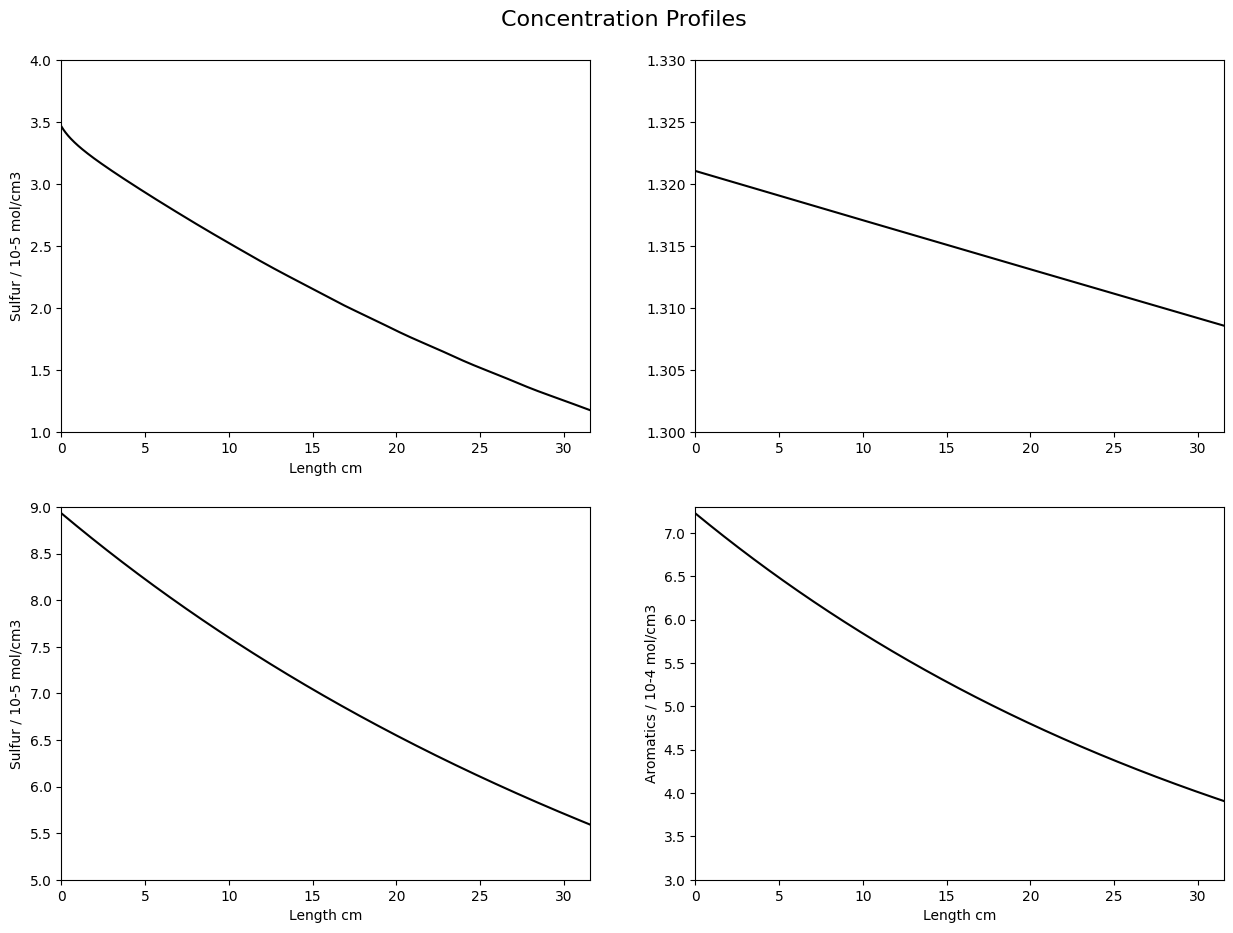

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the first dataset (y_values1) on the left axis (Y-axis)
ax[0,0].plot(t_eval, cL0_fun*1e5, color='black')

ax[0,0].set_xlim(0,z)
ax[0,0].set_ylim(1,4)

# Add labels and a legend
ax[0,0].set_xlabel('Length cm')
ax[0,0].set_ylabel('Sulfur / 10-5 mol/cm3', color='black')

ax[0,1].plot(t_eval, cL1_fun*1e6, color='black')

ax[0,1].set_xlim(0,z)
ax[0,1].set_ylim(1.300,1.330)

# Add labels and a legend
ax[1,0].set_xlabel('Length cm')
ax[1,0].set_ylabel('Basic nitrogen / 10-7 mol/cm3', color='black')

ax[1,0].plot(t_eval, cL2_fun*1e7, color='black')

ax[1,0].set_xlim(0,z)
ax[1,0].set_ylim(5,9)

# Add labels and a legend
ax[1,0].set_xlabel('Length cm')
ax[1,0].set_ylabel('Sulfur / 10-5 mol/cm3', color='black')

ax[1,1].plot(t_eval, cL3_fun*1e4, color='black')

ax[1,1].set_xlim(0,z)
ax[1,1].set_ylim(3,7.3)

# Add labels and a legend
ax[1,1].set_xlabel('Length cm')
ax[1,1].set_ylabel('Aromatics / 10-4 mol/cm3', color='black')

# Add a title to the entire figure
plt.suptitle("Concentration Profiles", fontsize=16)

# Adjust spacing between the title and the subplots
plt.subplots_adjust(top=0.93)

# Display the graph
plt.show()